In [27]:
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim

import torchvision.transforms as T
import torch.nn.functional as F


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
## data generation
def gen_x(num_samples):
    return np.sign(np.random.normal(0.,1.,[num_samples,1]))

def gen_y(x, num_samples, var):
    return x + np.random.normal(0.,np.sqrt(var),[num_samples,1])

In [29]:
num_samples = 1000000
var = 2.0
x = gen_x(num_samples)
y = gen_y(x, num_samples, var)

mi = 1/2 *(np.log(1 + ( 1/var )))

In [30]:
print(mi)


0.2027325540540822


In [31]:
class MIEstimator1(nn.Module):
    def __init__(self, d):
        super(MIEstimator1, self).__init__()
        self.fc1 = nn.Linear(1, d)
        self.fc2 = nn.Linear(1, d)
        self.fc3 = nn.Linear(d, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2  
    
class MIEstimator2(nn.Module):
    def __init__(self, size1, size2):
        super(MIEstimator2, self).__init__()

        # Vanilla MLP
        self.net = nn.Sequential(
            nn.Linear(size1 + size2, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1),
        )

    # Gradient for JSD mutual information estimation and EB-based estimation
    def forward(self, x1, x2):
        pos = self.net(torch.cat([x1, x2], 1))  # Positive Samples
        neg = self.net(torch.cat([torch.roll(x1, 1, 0), x2], 1))
        grad = F.softplus(-pos).mean() - F.softplus(neg).mean()
        out = pos.mean() - neg.exp().mean() + 1
        return grad, out

In [32]:
model = MIEstimator1(10)
n_epoch = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
MI_hist = []
for epoch in range(n_epoch):
    x_sample = gen_x(num_samples)
    y_sample = gen_y(x_sample, num_samples, var)
    y_shuffle = np.random.permutation(y_sample)
    
    x_sample = torch.from_numpy(x_sample).type(torch.FloatTensor)
    y_sample = torch.from_numpy(y_sample).type(torch.FloatTensor)
    y_shuffle = torch.from_numpy(y_shuffle).type(torch.FloatTensor)  
    
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)

    loss = - (torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y))))
    MI_hist.append(-1 * loss.data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

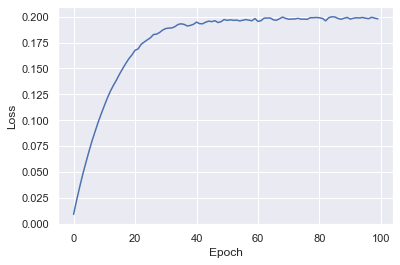

In [33]:
sns.set()
plt.plot(range(0, n_epoch), MI_hist, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();